- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from googlenet_pytorch import GoogLeNet 


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [5]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    #
    #googlenet, shufflenet, mobilenet 
    #

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "shufflenet":
        """ shufflenet
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "mobilenet":
        """ mobilenet
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [10]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.7776 Acc: 0.7512
val Loss: 0.5222 Acc: 0.9049

Epoch 1/299
----------
train Loss: 0.5170 Acc: 0.8623
val Loss: 0.3882 Acc: 0.9161

Epoch 2/299
----------
train Loss: 0.4381 Acc: 0.8712
val Loss: 0.3283 Acc: 0.9186

Epoch 3/299
----------
train Loss: 0.4009 Acc: 0.8759
val Loss: 0.2888 Acc: 0.9336

Epoch 4/299
----------
train Loss: 0.3749 Acc: 0.8805
val Loss: 0.2695 Acc: 0.9265

Epoch 5/299
----------
train Loss: 0.3631 Acc: 0.8807
val Loss: 0.2533 Acc: 0.9307

Epoch 6/299
----------
train Loss: 0.3436 Acc: 0.8844
val Loss: 0.2367 Acc: 0.9348

Epoch 7/299
----------
train Loss: 0.3425 Acc: 0.8826
val Loss: 0.2311 Acc: 0.9357

Epoch 8/299
----------
train Loss: 0.3286 Acc: 0.8887
val Loss: 0.2207 Acc: 0.9398

Epoch 9/299
--

train Loss: 0.2381 Acc: 0.9101
val Loss: 0.1275 Acc: 0.9564

Epoch 94/299
----------
train Loss: 0.2463 Acc: 0.9098
val Loss: 0.1227 Acc: 0.9606

Epoch 95/299
----------
train Loss: 0.2385 Acc: 0.9094
val Loss: 0.1315 Acc: 0.9548

Epoch 96/299
----------
train Loss: 0.2436 Acc: 0.9070
val Loss: 0.1282 Acc: 0.9585

Epoch 97/299
----------
train Loss: 0.2401 Acc: 0.9132
val Loss: 0.1245 Acc: 0.9597

Epoch 98/299
----------
train Loss: 0.2361 Acc: 0.9148
val Loss: 0.1277 Acc: 0.9564

Epoch 99/299
----------
train Loss: 0.2374 Acc: 0.9092
val Loss: 0.1280 Acc: 0.9577

Epoch 100/299
----------
train Loss: 0.2390 Acc: 0.9114
val Loss: 0.1251 Acc: 0.9581

Epoch 101/299
----------
train Loss: 0.2330 Acc: 0.9136
val Loss: 0.1263 Acc: 0.9531

Epoch 102/299
----------
train Loss: 0.2278 Acc: 0.9161
val Loss: 0.1350 Acc: 0.9552

Epoch 103/299
----------
train Loss: 0.2366 Acc: 0.9140
val Loss: 0.1258 Acc: 0.9589

Epoch 104/299
----------
train Loss: 0.2263 Acc: 0.9167
val Loss: 0.1305 Acc: 0.9539


val Loss: 0.1201 Acc: 0.9597

Epoch 189/299
----------
train Loss: 0.2320 Acc: 0.9133
val Loss: 0.1132 Acc: 0.9618

Epoch 190/299
----------
train Loss: 0.2369 Acc: 0.9140
val Loss: 0.1162 Acc: 0.9601

Epoch 191/299
----------
train Loss: 0.2307 Acc: 0.9150
val Loss: 0.1187 Acc: 0.9610

Epoch 192/299
----------
train Loss: 0.2341 Acc: 0.9073
val Loss: 0.1168 Acc: 0.9606

Epoch 193/299
----------
train Loss: 0.2348 Acc: 0.9104
val Loss: 0.1160 Acc: 0.9593

Epoch 194/299
----------
train Loss: 0.2220 Acc: 0.9146
val Loss: 0.1431 Acc: 0.9498

Epoch 195/299
----------
train Loss: 0.2299 Acc: 0.9121
val Loss: 0.1343 Acc: 0.9514

Epoch 196/299
----------
train Loss: 0.2302 Acc: 0.9116
val Loss: 0.1319 Acc: 0.9527

Epoch 197/299
----------
train Loss: 0.2281 Acc: 0.9147
val Loss: 0.1214 Acc: 0.9581

Epoch 198/299
----------
train Loss: 0.2246 Acc: 0.9157
val Loss: 0.1123 Acc: 0.9635

Epoch 199/299
----------
train Loss: 0.2293 Acc: 0.9160
val Loss: 0.1165 Acc: 0.9597

Epoch 200/299
----------

train Loss: 0.2265 Acc: 0.9146
val Loss: 0.1143 Acc: 0.9610

Epoch 285/299
----------
train Loss: 0.2251 Acc: 0.9163
val Loss: 0.1156 Acc: 0.9606

Epoch 286/299
----------
train Loss: 0.2262 Acc: 0.9141
val Loss: 0.1089 Acc: 0.9614

Epoch 287/299
----------
train Loss: 0.2295 Acc: 0.9181
val Loss: 0.1097 Acc: 0.9635

Epoch 288/299
----------
train Loss: 0.2228 Acc: 0.9175
val Loss: 0.1124 Acc: 0.9601

Epoch 289/299
----------
train Loss: 0.2269 Acc: 0.9155
val Loss: 0.1115 Acc: 0.9622

Epoch 290/299
----------
train Loss: 0.2272 Acc: 0.9133
val Loss: 0.1114 Acc: 0.9618

Epoch 291/299
----------
train Loss: 0.2270 Acc: 0.9184
val Loss: 0.1215 Acc: 0.9564

Epoch 292/299
----------
train Loss: 0.2331 Acc: 0.9140
val Loss: 0.1144 Acc: 0.9601

Epoch 293/299
----------
train Loss: 0.2284 Acc: 0.9143
val Loss: 0.1136 Acc: 0.9601

Epoch 294/299
----------
train Loss: 0.2330 Acc: 0.9113
val Loss: 0.1271 Acc: 0.9552

Epoch 295/299
----------
train Loss: 0.2325 Acc: 0.9145
val Loss: 0.1151 Acc: 0

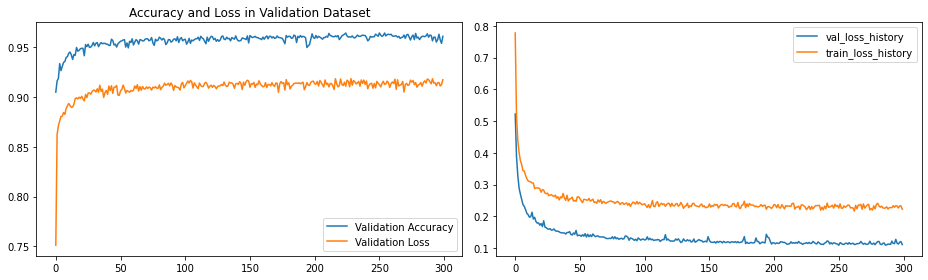


==== END ====
[[789   1   1]
 [  4 761  34]
 [  6  40 773]]

Sensitivity or recall total
0.9643005396430054

Sensitivity or recall per classes
[0.99747155 0.95244055 0.94383394]

Precision
[0.98748436 0.94887781 0.95668317]

F1 Score
[0.99245283 0.95065584 0.95021512]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -28.3277 Acc: 0.5989
val Loss: -55.8293 Acc: 0.6339

Epoch 1/299
----------
train Loss: -86.1092 Acc: 0.6382
val Loss: -114.6043 Acc: 0.6422

Epoch 2/299
----------
train Loss: -143.8617 Acc: 0.6294
val Loss: -172.4464 Acc: 0.6526

Epoch 3/299
----------
train Loss: -201.5401 Acc: 0.6288
val Loss: -226.4487 Acc: 0.6613

Epoch 4/299
----------
train Loss: -259.3115 Acc: 0.6271
val Loss: -282.5536 Acc: 0.6347

Epoch 5/299
-

train Loss: -4764.5962 Acc: 0.6320
val Loss: -4752.3736 Acc: 0.6617

Epoch 83/299
----------
train Loss: -4823.6915 Acc: 0.6322
val Loss: -4849.5212 Acc: 0.6509

Epoch 84/299
----------
train Loss: -4880.2767 Acc: 0.6331
val Loss: -4849.2918 Acc: 0.6484

Epoch 85/299
----------
train Loss: -4938.1950 Acc: 0.6329
val Loss: -4891.5219 Acc: 0.6372

Epoch 86/299
----------
train Loss: -4996.3676 Acc: 0.6335
val Loss: -4954.1303 Acc: 0.6397

Epoch 87/299
----------
train Loss: -5052.7213 Acc: 0.6323
val Loss: -4996.9382 Acc: 0.6542

Epoch 88/299
----------
train Loss: -5111.4101 Acc: 0.6370
val Loss: -5106.2349 Acc: 0.6459

Epoch 89/299
----------
train Loss: -5168.9454 Acc: 0.6354
val Loss: -5155.2551 Acc: 0.6418

Epoch 90/299
----------
train Loss: -5225.7885 Acc: 0.6320
val Loss: -5144.4308 Acc: 0.6509

Epoch 91/299
----------
train Loss: -5283.9219 Acc: 0.6340
val Loss: -5258.0636 Acc: 0.6563

Epoch 92/299
----------
train Loss: -5342.8440 Acc: 0.6338
val Loss: -5297.8345 Acc: 0.6530

E

val Loss: -9742.8840 Acc: 0.6501

Epoch 170/299
----------
train Loss: -9850.8290 Acc: 0.6311
val Loss: -9620.9286 Acc: 0.6496

Epoch 171/299
----------
train Loss: -9901.8974 Acc: 0.6328
val Loss: -9765.7128 Acc: 0.6430

Epoch 172/299
----------
train Loss: -9963.8934 Acc: 0.6337
val Loss: -9818.6852 Acc: 0.6609

Epoch 173/299
----------
train Loss: -10021.1341 Acc: 0.6339
val Loss: -9893.8332 Acc: 0.6517

Epoch 174/299
----------
train Loss: -10080.6862 Acc: 0.6338
val Loss: -9823.1208 Acc: 0.6633

Epoch 175/299
----------
train Loss: -10136.8450 Acc: 0.6344
val Loss: -10054.6517 Acc: 0.6463

Epoch 176/299
----------
train Loss: -10196.4300 Acc: 0.6328
val Loss: -10231.0513 Acc: 0.6380

Epoch 177/299
----------
train Loss: -10252.4744 Acc: 0.6326
val Loss: -10238.9096 Acc: 0.6314

Epoch 178/299
----------
train Loss: -10311.0670 Acc: 0.6308
val Loss: -10203.9741 Acc: 0.6484

Epoch 179/299
----------
train Loss: -10364.3988 Acc: 0.6301
val Loss: -10291.9800 Acc: 0.6426

Epoch 180/299


train Loss: -14761.3902 Acc: 0.6366
val Loss: -14627.7310 Acc: 0.6376

Epoch 256/299
----------
train Loss: -14813.4730 Acc: 0.6337
val Loss: -14559.9936 Acc: 0.6513

Epoch 257/299
----------
train Loss: -14874.5795 Acc: 0.6323
val Loss: -14685.7057 Acc: 0.6505

Epoch 258/299
----------
train Loss: -14932.4076 Acc: 0.6323
val Loss: -14596.0845 Acc: 0.6496

Epoch 259/299
----------
train Loss: -14996.2193 Acc: 0.6338
val Loss: -14776.0654 Acc: 0.6584

Epoch 260/299
----------
train Loss: -15047.6739 Acc: 0.6292
val Loss: -14888.3926 Acc: 0.6667

Epoch 261/299
----------
train Loss: -15102.9473 Acc: 0.6343
val Loss: -14876.4461 Acc: 0.6384

Epoch 262/299
----------
train Loss: -15165.5186 Acc: 0.6298
val Loss: -15037.2936 Acc: 0.6501

Epoch 263/299
----------
train Loss: -15220.7079 Acc: 0.6323
val Loss: -15106.9516 Acc: 0.6517

Epoch 264/299
----------
train Loss: -15285.7238 Acc: 0.6342
val Loss: -15172.4025 Acc: 0.6542

Epoch 265/299
----------
train Loss: -15336.8735 Acc: 0.6344
val 

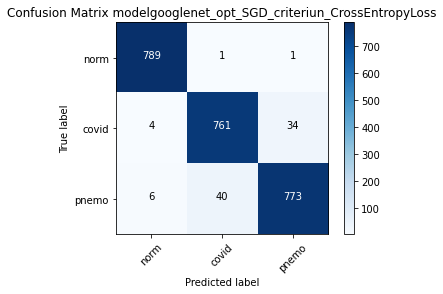

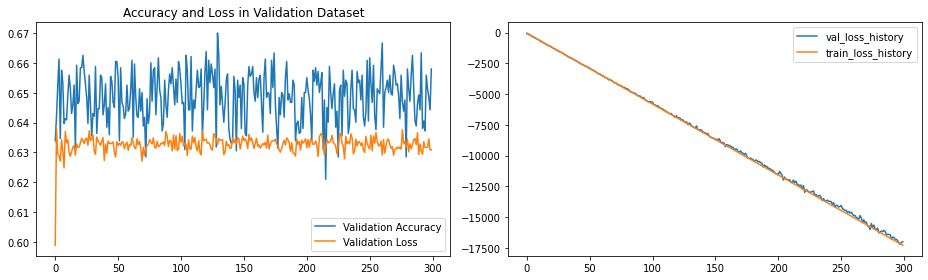


==== END ====
[[786   5   0]
 [ 37 761   1]
 [370 382  67]]

Sensitivity or recall total
0.6699875466998755

Sensitivity or recall per classes
[0.99 0.95 0.08]

Precision
[0.66 0.66 0.99]

F1 Score
[0.79 0.78 0.15]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.7376 Acc: 0.7721
val Loss: 0.4695 Acc: 0.9066

Epoch 1/299
----------
train Loss: 0.4704 Acc: 0.8656
val Loss: 0.3355 Acc: 0.9228

Epoch 2/299
----------
train Loss: 0.3938 Acc: 0.8775
val Loss: 0.2844 Acc: 0.9253

Epoch 3/299
----------
train Loss: 0.3583 Acc: 0.8826
val Loss: 0.2392 Acc: 0.9377

Epoch 4/299
----------
train Loss: 0.3385 Acc: 0.8864
val Loss: 0.2250 Acc: 0.9386

Epoch 5/299
----------
train Loss: 0.3320 Acc: 0.8857
val Loss: 0.2157 Acc: 0.9402

Epoch 6/29

train Loss: 0.2483 Acc: 0.9066
val Loss: 0.1191 Acc: 0.9597

Epoch 91/299
----------
train Loss: 0.2273 Acc: 0.9152
val Loss: 0.1209 Acc: 0.9589

Epoch 92/299
----------
train Loss: 0.2225 Acc: 0.9174
val Loss: 0.1147 Acc: 0.9597

Epoch 93/299
----------
train Loss: 0.2294 Acc: 0.9118
val Loss: 0.1194 Acc: 0.9593

Epoch 94/299
----------
train Loss: 0.2316 Acc: 0.9098
val Loss: 0.1129 Acc: 0.9610

Epoch 95/299
----------
train Loss: 0.2319 Acc: 0.9109
val Loss: 0.1195 Acc: 0.9585

Epoch 96/299
----------
train Loss: 0.2286 Acc: 0.9151
val Loss: 0.1140 Acc: 0.9618

Epoch 97/299
----------
train Loss: 0.2322 Acc: 0.9134
val Loss: 0.1158 Acc: 0.9593

Epoch 98/299
----------
train Loss: 0.2275 Acc: 0.9110
val Loss: 0.1239 Acc: 0.9548

Epoch 99/299
----------
train Loss: 0.2278 Acc: 0.9145
val Loss: 0.1211 Acc: 0.9589

Epoch 100/299
----------
train Loss: 0.2374 Acc: 0.9079
val Loss: 0.1107 Acc: 0.9631

Epoch 101/299
----------
train Loss: 0.2283 Acc: 0.9173
val Loss: 0.1137 Acc: 0.9593

Ep

train Loss: 0.2219 Acc: 0.9161
val Loss: 0.1141 Acc: 0.9610

Epoch 187/299
----------
train Loss: 0.2312 Acc: 0.9112
val Loss: 0.1064 Acc: 0.9610

Epoch 188/299
----------
train Loss: 0.2385 Acc: 0.9086
val Loss: 0.1081 Acc: 0.9626

Epoch 189/299
----------
train Loss: 0.2271 Acc: 0.9132
val Loss: 0.1144 Acc: 0.9618

Epoch 190/299
----------
train Loss: 0.2275 Acc: 0.9137
val Loss: 0.1099 Acc: 0.9626

Epoch 191/299
----------
train Loss: 0.2365 Acc: 0.9103
val Loss: 0.1114 Acc: 0.9614

Epoch 192/299
----------
train Loss: 0.2300 Acc: 0.9130
val Loss: 0.1124 Acc: 0.9618

Epoch 193/299
----------
train Loss: 0.2318 Acc: 0.9156
val Loss: 0.1159 Acc: 0.9614

Epoch 194/299
----------
train Loss: 0.2159 Acc: 0.9186
val Loss: 0.1079 Acc: 0.9622

Epoch 195/299
----------
train Loss: 0.2271 Acc: 0.9149
val Loss: 0.1074 Acc: 0.9606

Epoch 196/299
----------
train Loss: 0.2322 Acc: 0.9124
val Loss: 0.1129 Acc: 0.9610

Epoch 197/299
----------
train Loss: 0.2292 Acc: 0.9148
val Loss: 0.1093 Acc: 0

val Loss: 0.1179 Acc: 0.9585

Epoch 282/299
----------
train Loss: 0.2360 Acc: 0.9139
val Loss: 0.1144 Acc: 0.9610

Epoch 283/299
----------
train Loss: 0.2287 Acc: 0.9142
val Loss: 0.1089 Acc: 0.9614

Epoch 284/299
----------
train Loss: 0.2268 Acc: 0.9151
val Loss: 0.1077 Acc: 0.9631

Epoch 285/299
----------
train Loss: 0.2295 Acc: 0.9127
val Loss: 0.1083 Acc: 0.9601

Epoch 286/299
----------
train Loss: 0.2234 Acc: 0.9161
val Loss: 0.1077 Acc: 0.9614

Epoch 287/299
----------
train Loss: 0.2311 Acc: 0.9120
val Loss: 0.1046 Acc: 0.9618

Epoch 288/299
----------
train Loss: 0.2322 Acc: 0.9122
val Loss: 0.1072 Acc: 0.9626

Epoch 289/299
----------
train Loss: 0.2233 Acc: 0.9139
val Loss: 0.1064 Acc: 0.9618

Epoch 290/299
----------
train Loss: 0.2298 Acc: 0.9152
val Loss: 0.1136 Acc: 0.9585

Epoch 291/299
----------
train Loss: 0.2290 Acc: 0.9155
val Loss: 0.1107 Acc: 0.9614

Epoch 292/299
----------
train Loss: 0.2143 Acc: 0.9177
val Loss: 0.1139 Acc: 0.9593

Epoch 293/299
----------

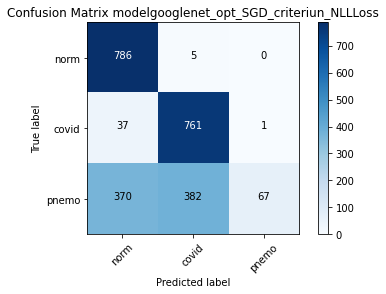

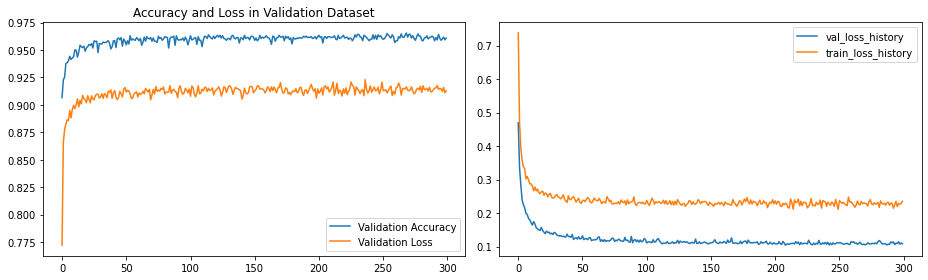


==== END ====
[[789   1   1]
 [  4 769  26]
 [  6  45 768]]

Sensitivity or recall total
0.9655458696554587

Sensitivity or recall per classes
[1.   0.96 0.94]

Precision
[0.99 0.94 0.97]

F1 Score
[0.99 0.95 0.95]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -18.7763 Acc: 0.3265
val Loss: -37.1729 Acc: 0.4280

Epoch 1/299
----------
train Loss: -56.3388 Acc: 0.4193
val Loss: -75.6146 Acc: 0.5455

Epoch 2/299
----------
train Loss: -93.8762 Acc: 0.5605
val Loss: -112.3333 Acc: 0.5824

Epoch 3/299
----------
train Loss: -131.3418 Acc: 0.6821
val Loss: -149.3698 Acc: 0.7323

Epoch 4/299
----------
train Loss: -168.8551 Acc: 0.6477
val Loss: -185.5036 Acc: 0.6463

Epoch 5/299
----------
train Loss: -206.3177 Acc: 0.6526
val Loss: -2

train Loss: -3127.0105 Acc: 0.6336
val Loss: -3103.0609 Acc: 0.6430

Epoch 84/299
----------
train Loss: -3165.2194 Acc: 0.6355
val Loss: -3103.1271 Acc: 0.6467

Epoch 85/299
----------
train Loss: -3203.3914 Acc: 0.6368
val Loss: -3179.0637 Acc: 0.6476

Epoch 86/299
----------
train Loss: -3240.4575 Acc: 0.6383
val Loss: -3226.7186 Acc: 0.6459

Epoch 87/299
----------
train Loss: -3277.7301 Acc: 0.6330
val Loss: -3274.4725 Acc: 0.6384

Epoch 88/299
----------
train Loss: -3315.5637 Acc: 0.6356
val Loss: -3309.9855 Acc: 0.6389

Epoch 89/299
----------
train Loss: -3352.6749 Acc: 0.6324
val Loss: -3376.9730 Acc: 0.6467

Epoch 90/299
----------
train Loss: -3391.0367 Acc: 0.6325
val Loss: -3389.1838 Acc: 0.6393

Epoch 91/299
----------
train Loss: -3429.0021 Acc: 0.6330
val Loss: -3406.6692 Acc: 0.6409

Epoch 92/299
----------
train Loss: -3465.0886 Acc: 0.6310
val Loss: -3430.8673 Acc: 0.6459

Epoch 93/299
----------
train Loss: -3502.2684 Acc: 0.6316
val Loss: -3520.1799 Acc: 0.6405

E

val Loss: -6320.7607 Acc: 0.6451

Epoch 171/299
----------
train Loss: -6424.9951 Acc: 0.6295
val Loss: -6283.1191 Acc: 0.6384

Epoch 172/299
----------
train Loss: -6463.4028 Acc: 0.6286
val Loss: -6272.4873 Acc: 0.6467

Epoch 173/299
----------
train Loss: -6497.3833 Acc: 0.6310
val Loss: -6503.2012 Acc: 0.6459

Epoch 174/299
----------
train Loss: -6537.3038 Acc: 0.6346
val Loss: -6474.3996 Acc: 0.6434

Epoch 175/299
----------
train Loss: -6575.6844 Acc: 0.6348
val Loss: -6579.1571 Acc: 0.6430

Epoch 176/299
----------
train Loss: -6611.1486 Acc: 0.6298
val Loss: -6503.7837 Acc: 0.6459

Epoch 177/299
----------
train Loss: -6645.9103 Acc: 0.6334
val Loss: -6563.7250 Acc: 0.6422

Epoch 178/299
----------
train Loss: -6685.8550 Acc: 0.6314
val Loss: -6648.8170 Acc: 0.6281

Epoch 179/299
----------
train Loss: -6723.0092 Acc: 0.6312
val Loss: -6674.4871 Acc: 0.6459

Epoch 180/299
----------
train Loss: -6761.2518 Acc: 0.6315
val Loss: -6800.7215 Acc: 0.6372

Epoch 181/299
----------
t

train Loss: -9682.7555 Acc: 0.6300
val Loss: -9472.9427 Acc: 0.6413

Epoch 259/299
----------
train Loss: -9720.4503 Acc: 0.6299
val Loss: -9480.1431 Acc: 0.6393

Epoch 260/299
----------
train Loss: -9759.5795 Acc: 0.6287
val Loss: -9705.0996 Acc: 0.6397

Epoch 261/299
----------
train Loss: -9795.6159 Acc: 0.6322
val Loss: -9792.6748 Acc: 0.6480

Epoch 262/299
----------
train Loss: -9833.0494 Acc: 0.6311
val Loss: -9813.5538 Acc: 0.6364

Epoch 263/299
----------
train Loss: -9868.1890 Acc: 0.6313
val Loss: -9936.2332 Acc: 0.6393

Epoch 264/299
----------
train Loss: -9906.8697 Acc: 0.6283
val Loss: -9912.3688 Acc: 0.6235

Epoch 265/299
----------
train Loss: -9945.4041 Acc: 0.6319
val Loss: -9850.1896 Acc: 0.6472

Epoch 266/299
----------
train Loss: -9981.3685 Acc: 0.6339
val Loss: -9903.8469 Acc: 0.6397

Epoch 267/299
----------
train Loss: -10020.7260 Acc: 0.6332
val Loss: -10011.8420 Acc: 0.6434

Epoch 268/299
----------
train Loss: -10053.5222 Acc: 0.6321
val Loss: -10036.9548 

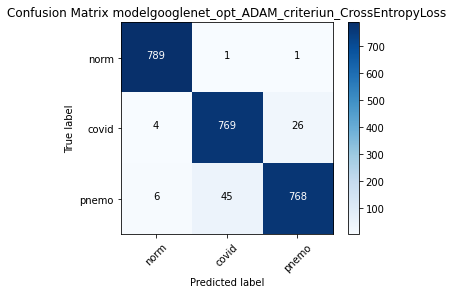

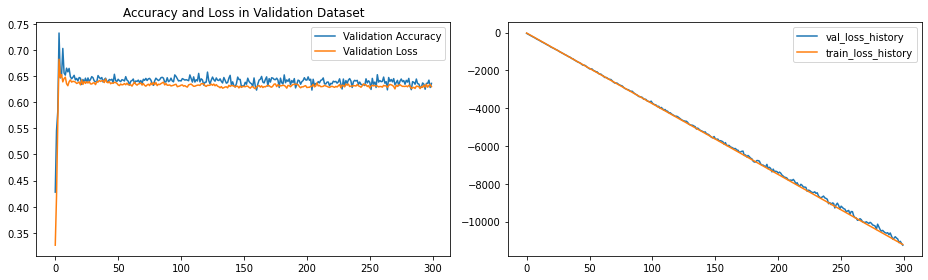


==== END ====
[[610 134  47]
 [  8 781  10]
 [ 25 421 373]]

Sensitivity or recall total
0.7322540473225405

Sensitivity or recall per classes
[0.77 0.98 0.46]

Precision
[0.95 0.58 0.87]

F1 Score
[0.85 0.73 0.6 ]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.6960 Acc: 0.7854
val Loss: 0.4473 Acc: 0.9112

Epoch 1/299
----------
train Loss: 0.4658 Acc: 0.8584
val Loss: 0.3205 Acc: 0.9278

Epoch 2/299
----------
train Loss: 0.3938 Acc: 0.8756
val Loss: 0.2691 Acc: 0.9290

Epoch 3/299
----------
train Loss: 0.3441 Acc: 0.8902
val Loss: 0.2361 Acc: 0.9365

Epoch 4/299
----------
train Loss: 0.3355 Acc: 0.8826
val Loss: 0.2177 Acc: 0.9406

Epoch 5/299
----------
train Loss: 0.3191 Acc: 0.8933
val Loss: 0.2054 Acc: 0.9431

Epoch 6/29

train Loss: 0.2314 Acc: 0.9139
val Loss: 0.1171 Acc: 0.9610

Epoch 91/299
----------
train Loss: 0.2329 Acc: 0.9161
val Loss: 0.1178 Acc: 0.9593

Epoch 92/299
----------
train Loss: 0.2292 Acc: 0.9133
val Loss: 0.1174 Acc: 0.9601

Epoch 93/299
----------
train Loss: 0.2332 Acc: 0.9103
val Loss: 0.1174 Acc: 0.9568

Epoch 94/299
----------
train Loss: 0.2352 Acc: 0.9118
val Loss: 0.1164 Acc: 0.9610

Epoch 95/299
----------
train Loss: 0.2276 Acc: 0.9153
val Loss: 0.1131 Acc: 0.9589

Epoch 96/299
----------
train Loss: 0.2402 Acc: 0.9099
val Loss: 0.1119 Acc: 0.9618

Epoch 97/299
----------
train Loss: 0.2325 Acc: 0.9116
val Loss: 0.1156 Acc: 0.9606

Epoch 98/299
----------
train Loss: 0.2334 Acc: 0.9096
val Loss: 0.1142 Acc: 0.9622

Epoch 99/299
----------
train Loss: 0.2270 Acc: 0.9151
val Loss: 0.1144 Acc: 0.9606

Epoch 100/299
----------
train Loss: 0.2315 Acc: 0.9121
val Loss: 0.1152 Acc: 0.9618

Epoch 101/299
----------
train Loss: 0.2312 Acc: 0.9111
val Loss: 0.1096 Acc: 0.9618

Ep

train Loss: 0.2350 Acc: 0.9121
val Loss: 0.1120 Acc: 0.9622

Epoch 187/299
----------
train Loss: 0.2297 Acc: 0.9133
val Loss: 0.1058 Acc: 0.9631

Epoch 188/299
----------
train Loss: 0.2318 Acc: 0.9125
val Loss: 0.1056 Acc: 0.9622

Epoch 189/299
----------
train Loss: 0.2331 Acc: 0.9137
val Loss: 0.1103 Acc: 0.9614

Epoch 190/299
----------
train Loss: 0.2325 Acc: 0.9110
val Loss: 0.1092 Acc: 0.9622

Epoch 191/299
----------
train Loss: 0.2384 Acc: 0.9127
val Loss: 0.1098 Acc: 0.9601

Epoch 192/299
----------
train Loss: 0.2333 Acc: 0.9116
val Loss: 0.1072 Acc: 0.9626

Epoch 193/299
----------
train Loss: 0.2273 Acc: 0.9146
val Loss: 0.1074 Acc: 0.9601

Epoch 194/299
----------
train Loss: 0.2297 Acc: 0.9128
val Loss: 0.1061 Acc: 0.9635

Epoch 195/299
----------
train Loss: 0.2281 Acc: 0.9136
val Loss: 0.1097 Acc: 0.9593

Epoch 196/299
----------
train Loss: 0.2324 Acc: 0.9097
val Loss: 0.1078 Acc: 0.9614

Epoch 197/299
----------
train Loss: 0.2306 Acc: 0.9146
val Loss: 0.1062 Acc: 0

val Loss: 0.1116 Acc: 0.9601

Epoch 282/299
----------
train Loss: 0.2310 Acc: 0.9104
val Loss: 0.1066 Acc: 0.9622

Epoch 283/299
----------
train Loss: 0.2278 Acc: 0.9108
val Loss: 0.1078 Acc: 0.9614

Epoch 284/299
----------
train Loss: 0.2256 Acc: 0.9146
val Loss: 0.1086 Acc: 0.9622

Epoch 285/299
----------
train Loss: 0.2283 Acc: 0.9162
val Loss: 0.1085 Acc: 0.9597

Epoch 286/299
----------
train Loss: 0.2296 Acc: 0.9109
val Loss: 0.1122 Acc: 0.9606

Epoch 287/299
----------
train Loss: 0.2264 Acc: 0.9128
val Loss: 0.1132 Acc: 0.9614

Epoch 288/299
----------
train Loss: 0.2284 Acc: 0.9140
val Loss: 0.1058 Acc: 0.9622

Epoch 289/299
----------
train Loss: 0.2189 Acc: 0.9165
val Loss: 0.1081 Acc: 0.9618

Epoch 290/299
----------
train Loss: 0.2243 Acc: 0.9154
val Loss: 0.1066 Acc: 0.9635

Epoch 291/299
----------
train Loss: 0.2284 Acc: 0.9155
val Loss: 0.1112 Acc: 0.9610

Epoch 292/299
----------
train Loss: 0.2315 Acc: 0.9132
val Loss: 0.1066 Acc: 0.9610

Epoch 293/299
----------

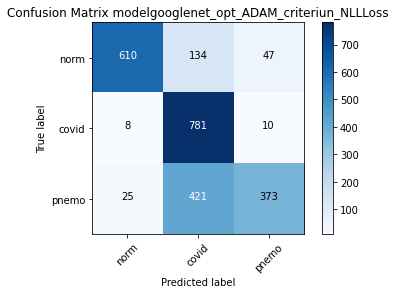

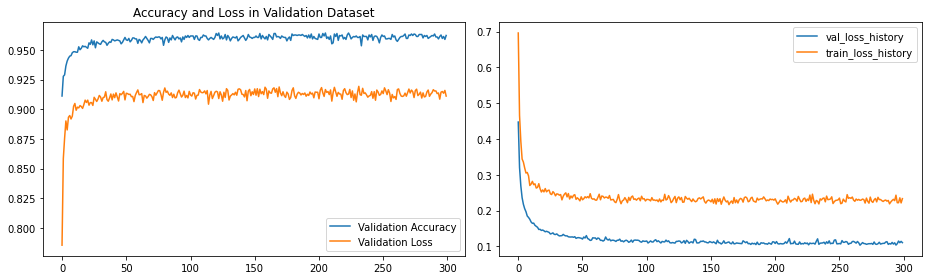


==== END ====
[[789   1   1]
 [  4 757  38]
 [  6  36 777]]

Sensitivity or recall total
0.9643005396430054

Sensitivity or recall per classes
[1.   0.95 0.95]

Precision
[0.99 0.95 0.95]

F1 Score
[0.99 0.95 0.95]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -22.6546 Acc: 0.3902
val Loss: -41.0748 Acc: 0.3719

Epoch 1/299
----------
train Loss: -60.3212 Acc: 0.4421
val Loss: -78.5194 Acc: 0.6135

Epoch 2/299
----------
train Loss: -97.7704 Acc: 0.5424
val Loss: -114.9629 Acc: 0.6156

Epoch 3/299
----------
train Loss: -135.1909 Acc: 0.5999
val Loss: -153.1589 Acc: 0.6339

Epoch 4/299
----------
train Loss: -172.5628 Acc: 0.6241
val Loss: -190.6728 Acc: 0.6389

Epoch 5/299
----------
train Loss: -209.9561 Acc: 0.6212
val Loss: -2

train Loss: -3127.8676 Acc: 0.6371
val Loss: -3139.3250 Acc: 0.6517

Epoch 84/299
----------
train Loss: -3164.7044 Acc: 0.6382
val Loss: -3173.2649 Acc: 0.6546

Epoch 85/299
----------
train Loss: -3203.2496 Acc: 0.6375
val Loss: -3177.3788 Acc: 0.6517

Epoch 86/299
----------
train Loss: -3239.4330 Acc: 0.6397
val Loss: -3233.0385 Acc: 0.6496

Epoch 87/299
----------
train Loss: -3276.7187 Acc: 0.6374
val Loss: -3268.3255 Acc: 0.6472

Epoch 88/299
----------
train Loss: -3314.4851 Acc: 0.6351
val Loss: -3280.6714 Acc: 0.6434

Epoch 89/299
----------
train Loss: -3352.8822 Acc: 0.6362
val Loss: -3316.1914 Acc: 0.6521

Epoch 90/299
----------
train Loss: -3388.9231 Acc: 0.6367
val Loss: -3369.9843 Acc: 0.6496

Epoch 91/299
----------
train Loss: -3426.1866 Acc: 0.6363
val Loss: -3438.0434 Acc: 0.6496

Epoch 92/299
----------
train Loss: -3462.7141 Acc: 0.6390
val Loss: -3467.9653 Acc: 0.6480

Epoch 93/299
----------
train Loss: -3501.9554 Acc: 0.6401
val Loss: -3426.8104 Acc: 0.6451

E

val Loss: -6378.9101 Acc: 0.6434

Epoch 171/299
----------
train Loss: -6418.2602 Acc: 0.6333
val Loss: -6426.2157 Acc: 0.6434

Epoch 172/299
----------
train Loss: -6454.6668 Acc: 0.6340
val Loss: -6455.5645 Acc: 0.6314

Epoch 173/299
----------
train Loss: -6496.2543 Acc: 0.6349
val Loss: -6419.1901 Acc: 0.6413

Epoch 174/299
----------
train Loss: -6530.6078 Acc: 0.6348
val Loss: -6430.3796 Acc: 0.6443

Epoch 175/299
----------
train Loss: -6568.8941 Acc: 0.6341
val Loss: -6457.1475 Acc: 0.6513

Epoch 176/299
----------
train Loss: -6602.9689 Acc: 0.6316
val Loss: -6568.5501 Acc: 0.6384

Epoch 177/299
----------
train Loss: -6643.1794 Acc: 0.6360
val Loss: -6693.6155 Acc: 0.6372

Epoch 178/299
----------
train Loss: -6681.1517 Acc: 0.6356
val Loss: -6678.5627 Acc: 0.6359

Epoch 179/299
----------
train Loss: -6717.8001 Acc: 0.6356
val Loss: -6626.7083 Acc: 0.6413

Epoch 180/299
----------
train Loss: -6754.7605 Acc: 0.6334
val Loss: -6698.6710 Acc: 0.6480

Epoch 181/299
----------
t

train Loss: -9671.1029 Acc: 0.6330
val Loss: -9640.5494 Acc: 0.6488

Epoch 259/299
----------
train Loss: -9712.1625 Acc: 0.6346
val Loss: -9514.2659 Acc: 0.6488

Epoch 260/299
----------
train Loss: -9748.1050 Acc: 0.6342
val Loss: -9513.6463 Acc: 0.6488

Epoch 261/299
----------
train Loss: -9784.2838 Acc: 0.6356
val Loss: -9668.5391 Acc: 0.6393

Epoch 262/299
----------
train Loss: -9822.7809 Acc: 0.6326
val Loss: -9820.4183 Acc: 0.6430

Epoch 263/299
----------
train Loss: -9861.7744 Acc: 0.6354
val Loss: -9598.4216 Acc: 0.6459

Epoch 264/299
----------
train Loss: -9897.5769 Acc: 0.6333
val Loss: -9745.1653 Acc: 0.6451

Epoch 265/299
----------
train Loss: -9936.2724 Acc: 0.6374
val Loss: -9737.0796 Acc: 0.6422

Epoch 266/299
----------
train Loss: -9971.5014 Acc: 0.6379
val Loss: -9893.7231 Acc: 0.6389

Epoch 267/299
----------
train Loss: -10009.9877 Acc: 0.6339
val Loss: -9894.8078 Acc: 0.6372

Epoch 268/299
----------
train Loss: -10047.5552 Acc: 0.6359
val Loss: -9987.5226 Ac

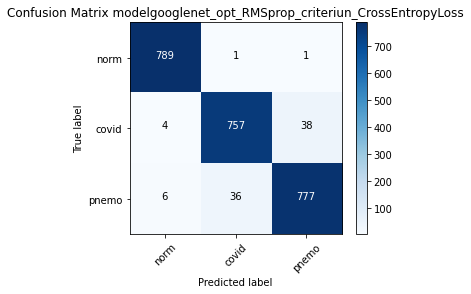

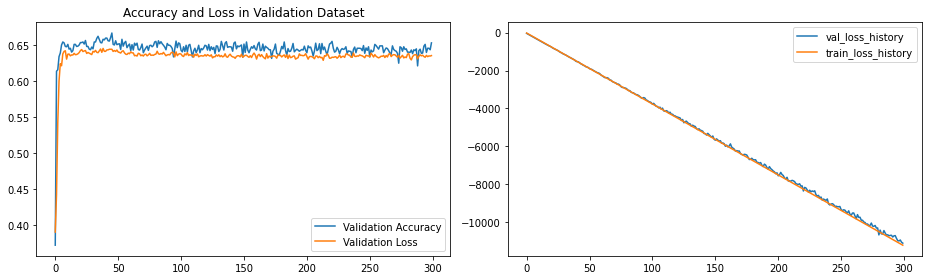


==== END ====
[[780  11   0]
 [ 32 766   1]
 [326 433  60]]

Sensitivity or recall total
0.6666666666666666

Sensitivity or recall per classes
[0.99 0.96 0.07]

Precision
[0.69 0.63 0.98]

F1 Score
[0.81 0.76 0.14]
Confusion matrix, without normalization


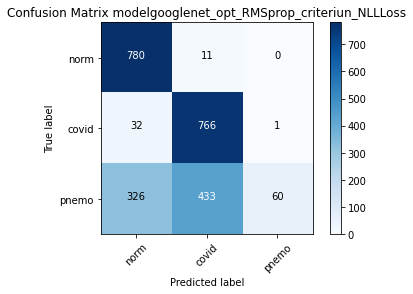

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['googlenet'] #['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet' ]
lrs = [1e-4]
_epoch = [300]Est
batch_sizes = [8]
opt = [1, 2, 3]
crt = [1, 2]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                         
                        
                            
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        
                        
                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                        if _crt == 2:
                            criterion = nn.NLLLoss()
                            crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)
                        
                        

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion Matrix model'+_model+'_opt_'+opt_name+'_criteriun_'+crt_name)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [42]:
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,300)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/300
----------
train loss:  0.2861  acc: 0.8961
val loss:  0.1513  acc: 0.9481
epoch 2/300
----------
train loss:  0.1862  acc: 0.9335
val loss:  0.1124  acc: 0.9606
epoch 3/300
----------
train loss:  0.1733  acc: 0.9355
val loss:  0.1183  acc: 0.9597
epoch 4/300
----------
train loss:  0.1353  acc: 0.9514
val loss:  0.1139  acc: 0.9589
epoch 5/300
----------
train loss:  0.1371  acc: 0.9514
val loss:  0.1076  acc: 0.9618
epoch 6/300
----------
train loss:  0.1363  acc: 0.9499
val loss:  0.1058  acc: 0.9626
epoch 7/300
----------
train loss:  0.1365  acc: 0.9512
val loss:  0.1081  acc: 0.9606
epoch 8/300
----------


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [2]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [12]:
model_ft = GoogLeNet.from_pretrained('googlenet')
# ... image preprocessing as in the classification example ...
inputs = torch.randn(1, 3, 224, 224)
print(inputs.shape) # torch.Size([1, 3, 224, 224])

feature_extract = model_ft.extract_features(inputs)
print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

model_ft.eval()

Loaded pretrained weights for googlenet
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024, 7, 7])


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
model_ft.Layers
# # ... image preprocessing as in the classification example ...
# inputs = torch.randn(1, 3, 224, 224)
# print(inputs.shape) # torch.Size([1, 3, 224, 224])

# feature_extract = model_ft.extract_features(inputs)
# print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

# model_ft.eval()

AttributeError: 'ShuffleNetV2' object has no attribute 'Layers'

In [15]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
# ... image preprocessing as in the classification example ...
inputs = torch.randn(1, 3, 224, 224)
print(inputs.shape) # torch.Size([1, 3, 224, 224])

feature_extract = model_ft.fc(inputs)
print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

model_ft.eval()

torch.Size([1, 3, 224, 224])


RuntimeError: size mismatch, m1: [672 x 224], m2: [1024 x 1000] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41